# RUNNING ESM1V ON WT AND TEST SET

ESM1v (MAC)
- python3.11 -m venv esm1v
- activate it 
- python -m pip install --upgrade pip setuptools wheel
- python -m pip install torch fair-esm ipykernel

ESM1v (PC/CUDA)
- winget install Python.Python.3.11
- python -m pip install --upgrade pip setuptools wheel
- pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
- pip install fair-esm ipykernel numpy psutil
- python -m ipykernel install --user --name esm1v_cuda --display-name "esm1v_cuda (RTX3060)" 
- #made the venv visible to notebooks, VS Code can now attach to it. before that step  no Jupyter kernel entry point. 

NOTES:
* on multiple proces, cannot load ESM-1v once and “share it” across workers, CUDA contexts are per process, each OS process has its own CUDA context. With spawn (required for CUDA on Windows):workers do not inherit Python objects. On Linux you could theoretically:	fork()inherit memory pagesshare CPU tensors (copy-on-write). But CUDA + fork = undefined behavior. 

* track gpu usage while esm1v script running: nvidia-smi dmon -s pucvmt

* GPU 2.50/2.58 GB | CPU 99.3% | RAM 2.90 GB
    * GPU 2.50 / 2.58 GB -> 	Memory actively used by tensors (model weights + activations during forward). 2.58 GB = torch.cuda.memory_reserved() CUDA’s memory pool reserved for reuse (allocator buffer). how much memory PyTorch’s allocator has asked CUDA to give it so far.  2.50 / 2.58 GB is memory footprint, not utilization. ~2.5 GB = model weights + activations for one sequence. GPU memory is demand-driven, not capacity-drive, so increasing memory reserved. CORRECT WAY TO INCREASE GPU USAGE IS Use multiple processes and Each process loads: its own model copy + its own buffers (eg.) 3 processes ≈ 3 × 2.5 GB ≈ 7.5 GB VRAM. Why GPU allocated is stuck around ~2.5 GB -> torch.cuda.memory_allocated() reports live tensors currently required for computation which doesnt exceed 2.5G 
        * Method 1 to nicrease GPU: FP16. 	Keep tokens as int64 (do NOT .half() them). Only the model weights / activations go FP16. 
        * Method 2: multiple python processes, need to first split into chunks the input esm1v_input.fasta. becuase On NVIDIA GPUs (including RTX 3060), FP16 is much faster, Tensor Cores are optimized for FP16, and is numerically safe for esm1v. 
    * CPU 98–100% ->Percent of one logical core, not all cores. Bottleneck rn is the batchsize being 1. CUDA kernel launches are sequential. 	Tokenization is tiny (milliseconds). 	The GPU is already saturated by each forward pass. There is no parallel work at the Python level. So doing torch.set_num_threads(16) shouldnt speed up as CPU is not the bottleneck as its not computing the matmuls, the gpu is. 
    * RAM 2.90Gb -> This is process RSS:Using more RAM would not make this faster. GBMemory usage ≠ GPU compute utilization. CUDA kernels can be fully busy with modest memory. You are GPU compute-bound, not memory-bound. High CPU % here is normal and unavoidable in Python-driven GPU inference. GPU memory numbers show correct ESM-1v residency. Increase BATCH_SIZE → more GPU memory used, fewer kernel launches (which is what the cpu is doing)

- how to make esm1v script take more memory than 1.2Gb? On MPS, memory use is demand-driven, not user-configurable. Need to increase batch ize. 
- ESM1v with CUDA ->  700 batches/min, totlaruntime =
- esm1v with CPU -> takes 21% CPU now on btop and 3.1Gb memB. after 13min at batch 988.  after 33min its at test2500 or abtch 2500. 
- esm1v on wt+test set with MPS -> taking 1.1Gb Memb, 1.2%CPU. Took 16min. Still have free 22% memory on btop so idk why before 1h ago i had 0 free mem. ok now i got 28% with only vscode + chatgpt app + terminal btop  
* "|" character is not recognized by wsl but is by os 

* WHY REGRESSION WEIGHTS NOT DOWNLOADING IN THE SCRIPT INSTALLING MODEL PART? If enabled (return_contacts=True), ESM produces a soft contact probability matrix:. Shape: (L × L). Value range: [0, 1]. Interpretation: probability that residues i and j are within ~8 Å (Cβ–Cβ). You can quantify how a mutation perturbs long-range residue interactions.Δ mean contacts of residue 160 . Δ contacts between loop 11 and core . Δ contact entropy. ANOTEHR USE CASE: Instead of mean-pooling residues, pool over contact-connected regions, pool active-site residues weighted by contact importance. This is not a 3D structure and not AlphaFold-level accuracy.

* for SFTP between the 2 machines need to do: lpwd, pwd, put esm1v_input.fasta, sudo nano /etc/hosts and COPY PASTE: IPADRESS bustinpc, now can do sftp justi@bustinpc easily 

* torch.cuda.empty_cache() (or torch.mps.empty_cache()) tells PyTorch: “Release any unused GPU memory that PyTorch is holding onto for reuse.”	del decides what can be freed. empty_cache() only frees already-dead tensors. 

* using what layer of esm for esm1v? -> ESM-1v is trained such that final layer is most predictive. All published ESM-1v mutation scores use final layer. Earlier layers encode syntax, not function. 

* on the first forward pass on MPS for a 650M-param transformer, This is Metal compiling and caching kernels. ESM-1v attention is O(L²), PETase ~290–310 aa → heavy. And on mac MPS does lazy kernel compilation, First invocation compiles all attention variants. This does not happen on CUDA (RTX 3060 would finish batch 1 in ~5–10 seconds).

* mean-pooled embeddings PER SEQ: One vector per sequence, Shape: (1280,), Easy to join with TSV later, Small (~5 KB per sequence)

* del tokens, reps: remove Python references → tensors can be freed. meaning temporary tensors that are computed. 

* torch.mps.empty_cache(): force PyTorch to return memory to macOS. Your Python process never keeps memory, so RSS stays ~1–2 GB even if you have 64 GB free. #WHATS RSS --> RSS = Resident Set Size. How much physical RAM the OS says your process is holding. PyTorch tensors Python objects Cached allocator memory. RSS = how much physical system RAM the OS currently assigns to your Python process.


* set_num_threads: number of threads used by intra-op CPU kernels (e.g. BLAS, MKL)
* set_num_interop_threads: number of threads used to schedule ops across CPU threads

* CPU threads are only used for:Tokenization + Python orchestration + Minor tensor setup

* cpu: CPU cores (BLAS / MKL / OpenMP), YES CAN MODIFY PYTORCH N THREADS, Matrix multiplies are multi-threaded Thread counts directly control performance. 

* mps: Apple GPU, NO. Transformer matmuls run on the GPU. If increase cpu threads to 16 while device=mps, You will see -> Slightly higher CPU usage

* cuda: NVIDIA GPU, CUDA does not use CPU threads for math, but CPU threads will be used for tokenization data loading python orchestration when running the esm1v script on windows w/ RTX gpu (meaning with CUDA)

* Attention outputs info: Contact prediction. Structure inference. Mechanistic interpretation

* per-residue esm embedding information: You want position-specific features (e.g. catalytic residues). You want to pool over regions (loops, active site). You want attention outside ESM (your own model) --> according to gpt its not needed for first-pass ranking (test set variant ranking) apparently --> Recommendation: Save mean-pooled (1280-dim) embeddings. Optionally later re-run per-residue only for top 200 variants. Note that per residue embeddings can help for: Active-site pooling Region-specific features Mechanistic feature. 

* fine-tuning means: You remove torch.no_grad(), You define a prediction head (e.g. linear layer on top of embeddings), You compute a loss (MSE / BCE / ranking loss) You call: loss.backward() and then optimizer.step() which updates ESM weights 

* ESM1v below script sequence of events (with repr33 layer): Compute embedding -> Save to disk (np.save(...)) -> Delete tensors to free memory

* ON CUDA: pip install torch --index-url https://download.pytorch.org/whl/cu121 actually pytorch packages the cuda toolkit version and cudnn version inside its wheel so the above gives 	•	CUDA runtime (e.g. cu121 = CUDA 12.1) + cuDNN + cuBLAS +	Everything needed for GPU matmul + attention. And ntoe that PyTorch wheel uses CUDA ≤12.1 while PC driver is 12.6. Writing .cu / .cpp code + Compiling with nvcc + Linking against CUDA + PyTorch + Managing GPU memory manually. PyTorch wheels already include compiled cuda kernels. 

* CUSTOM CUDA KERNELS: A CUDA kernel is a low-level GPU function written in CUDA C++ that runs directly on the GPU. Transformer attention is mathematically: QKᵀ → softmax → weighted sum; and O(L²) memory and compute. CUSTOM KERNELS implement this in different ways: Vanilla attention (slow, generic) + FlashAttention (custom CUDA kernel, fused ops, much faster) + xFormers attention (custom kernels + heuristics). AND ESM1v -> uses optimized attention kernels provided by PyTorch, On CUDA, PyTorch dispatches to highly optimized kernels. WRITING CUSTOM KERNEL BECOMES RELEVANT WHEN: Write a new architecture (not just fine-tune) + Optimize attention for very long sequences (e.g. >2k aa) + Implement physics-aware layers (e.g. distance-aware attention) + Build production inference engines + Compete with framework authors on speed. IN SUM: CUDA driver: lets GPU run code + PyTorch CUDA wheel: ships kernels + You: call models + Kernel authors: write CUDA.

* LATER ON CUDA KERNELS:  A structure-aware transformer + A protein-ligand attention model + A custom MD-aware network. eg. Build new architectures, Combine structure + docking + MD, Then CUDA kernels matter. CUDA kernels are not “cool tricks”. They are about unlocking model classes that otherwise cannot exist.  


In [ ]:
#Computed ESM1v delta features for 4674 pairs
import os
import numpy as np
import pandas as pd

TEST_DIR = "esm1v_outputs_clean"
WT_DIR   = "esm1v_outputs_wt"

def load_emb(dirpath, eid):
    path = os.path.join(dirpath, f"{eid}.npy")
    if not os.path.exists(path):
        return None
    return np.load(path)

def esm_delta_features(test_emb, wt_emb):
    delta = test_emb - wt_emb
    wt_norm = np.linalg.norm(wt_emb)
    test_norm = np.linalg.norm(test_emb)

    return {
        "l2": np.linalg.norm(delta),
        "l1": np.abs(delta).sum(),
        "cosine_dist": 1 - np.dot(test_emb, wt_emb) / (wt_norm * test_norm),
        "max_abs": np.max(np.abs(delta)),
        "mean_abs": np.mean(np.abs(delta)),
        "rel_l2": np.linalg.norm(delta) / wt_norm if wt_norm > 0 else np.nan,
        "wt_norm": wt_norm,
        "test_norm": test_norm,
    }

# ---------------- load map ----------------
map_df = pd.read_csv("test_wt_map.tsv", sep="\t")
assert map_df["test_id"].is_unique

rows = []
skipped = []

for _, r in map_df.iterrows():
    test_id = r["test_id"]
    wt_id   = r["wt_id"]

    te = load_emb(TEST_DIR, test_id)
    we = load_emb(WT_DIR, wt_id)

    # ---------- skip missing ----------
    if te is None or we is None:
        skipped.append((test_id, wt_id))
        continue

    feats = esm_delta_features(te, we)
    feats["test_id"] = test_id
    feats["wt_id"] = wt_id
    rows.append(feats)

esm_df = pd.DataFrame(rows)

print(f"Computed ESM1v delta features for {len(esm_df)} pairs")
print(f"Skipped {len(skipped)} pairs due to missing embeddings")

# Optional: inspect skipped
skipped_df = pd.DataFrame(skipped, columns=["test_id", "wt_id"])
print(skipped_df.head())

esm_df.head()


Computed ESM1v delta features for 4674 pairs
Skipped 314 pairs due to missing embeddings
                test_id            wt_id
0   tournament_test_746  tournament_wt_1
1   tournament_test_747  tournament_wt_1
2  tournament_test_2337  tournament_wt_2
3  tournament_test_3917  tournament_wt_3
4  tournament_test_4679  tournament_wt_4


,l2,l1,cosine_dist,max_abs,mean_abs,rel_l2,wt_norm,test_norm,test_id,wt_id
0,0.199552,5.606233,0.000024,0.023045,0.004380,0.007043,28.333979,28.312511,tournament_test_1,tournament_wt_1
1,0.679946,19.261877,0.000288,0.064639,0.015048,0.023998,28.333979,28.322910,tournament_test_2,tournament_wt_1
2,0.242335,6.847635,0.000036,0.022070,0.005350,0.008553,28.333979,28.320602,tournament_test_3,tournament_wt_1
3,0.231327,6.519629,0.000033,0.023539,0.005093,0.008164,28.333979,28.318571,tournament_test_4,tournament_wt_1
4,0.214823,6.035027,0.000029,0.025575,0.004715,0.007582,28.333979,28.317120,tournament_test_5,tournament_wt_1


In [ ]:
#SAVE ESM DELTA FEATURES 
esm_df.to_csv("esm1v_delta_features.tsv", sep="\t", index=False)
print("Saved esm1v_delta_features.tsv")

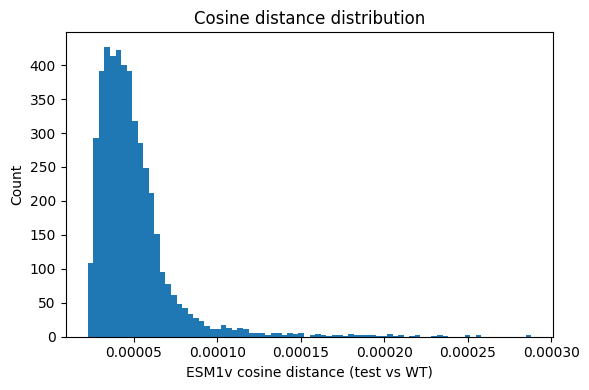

In [2]:
import matplotlib.pyplot as plt
import pandas as pd 
df = pd.read_csv("esm1v_delta_features.tsv", sep="\t")

df.head()
plt.figure(figsize=(6,4))
plt.hist(df["cosine_dist"], bins=80)
plt.xlabel("ESM1v cosine distance (test vs WT)")
plt.ylabel("Count")
plt.title("Cosine distance distribution")
plt.tight_layout()
plt.show()
# CAN WE add arrows to the below cosine distribution plot to annotate what PETase residue key region was modified in the .25 and .5  like put the mutations above 

In [3]:
# GET CLEAN TEST-SET ALIGNED POSITIONS BY LANDMARKS
# * appears ONLY when test mutation hits the landmark
import matplotlib.pyplot as plt

df = pd.read_csv("esm1v_delta_features.tsv", sep="\t")

df.head()

import pandas as pd
import re

# ---------- helpers ----------
def extract_pos(val):
    """Extract numeric residue index from WT alignment cell"""
    if pd.isna(val):
        return None
    if isinstance(val, (int, float)):
        return int(val)
    if isinstance(val, str):
        m = re.search(r"(\d+)", val)
        return int(m.group(1)) if m else None
    return None

def parse_single_mutation(mut):
    """Parse V26A -> 26"""
    if not isinstance(mut, str):
        return None
    m = re.fullmatch(r"[A-Z](\d+)[A-Z]", mut.strip())
    return int(m.group(1)) if m else None

# ---------- load inputs ----------
wt_align = pd.read_csv("wt_aligned_positions.tsv", sep="\t")
map_df   = pd.read_csv("test_wt_map_mut.tsv", sep="\t")

wt_align = wt_align.set_index("name")
landmark_cols = wt_align.columns.tolist()

rows = []
skipped = 0

# ---------- main loop ----------
for _, r in map_df.iterrows():
    test_id = r["test_id"]
    wt_id   = r["wt_id"]
    mut     = r["mutation"]

    if wt_id not in wt_align.index:
        skipped += 1
        continue

    wt_pos = parse_single_mutation(mut)

    # --- build clean numeric base row ---
    base = {}
    for col in landmark_cols:
        base[col] = extract_pos(wt_align.loc[wt_id, col])

    # --- annotate ONLY test mutation hits ---
    if wt_pos is not None:
        for col in landmark_cols:
            if base[col] == wt_pos:
                base[col] = f"*{mut}"

    base["test_id"]  = test_id
    base["wt_id"]    = wt_id
    base["mutation"] = mut

    rows.append(base)

# ---------- output ----------
test_aligned_df = pd.DataFrame(rows)
test_aligned_df.to_csv("test_aligned_positions.tsv", sep="\t", index=False)

print(f"Saved test_aligned_positions.tsv ({len(test_aligned_df)} rows)")
print(f"Skipped {skipped} rows with missing WT")

Saved test_aligned_positions.tsv (4988 rows)
Skipped 0 rows with missing WT


In [ ]:
#COUNT LANDMARK_HITS
import pandas as pd

esm_df   = pd.read_csv("esm1v_delta_features.tsv", sep="\t")
align_df = pd.read_csv("test_aligned_positions.tsv", sep="\t")

# merge ONCE
df = esm_df.merge(align_df, on="test_id", how="left")

landmark_cols = [
    "S160","D206","H237","Y87","W159","W185","S238","N241","M161","I208",
    "T88","A89","I218","S207","A209","R280","P181","S290","D186","S187",
    "C203","S214","C239","R90","L117","Q119","N233"
]

(df[landmark_cols]
 .astype(str)
 .apply(lambda c: c.str.startswith("*"))
 .sum()
 .sort_values(ascending=False)
 .head(10))

# does this test variant hit ANY landmark?
df["hits_landmark"] = (
    df[landmark_cols]
      .astype(str)
      .apply(lambda c: c.str.startswith("*"))
      .any(axis=1)
)

# quick sanity check
df["hits_landmark"].value_counts()

hits_landmark
False    4199
True      475
Name: count, dtype: int64

Cosine distance measures directional change in the 1280-D embedding, independent of overall magnitude. A mutation that subtly redistributes information across many dimensions can yield a large cosine shift even if per-dimension changes are modest. This makes cosine distance highly sensitive to coordinated, global semantic changes, which is why you see long, thin tails (rare but very strong effects).
	•	L2 / rel_l2 measure energy/magnitude change. They respond when many dimensions move substantially in absolute terms, but they are less sensitive to sign-coherent or direction-preserving rearrangements. This leads to tighter, more compact distributions.
	•	mean_abs and max_abs are dimensionwise summaries.
	•	mean_abs captures distributed perturbation (many small changes),
	•	max_abs captures localized spikes (one or few dimensions).
Their smoother violins indicate they act as stabilized aggregators, dampening extreme behavior seen in cosine.


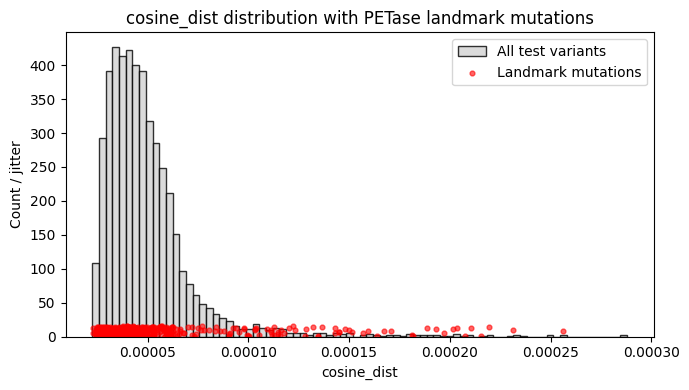

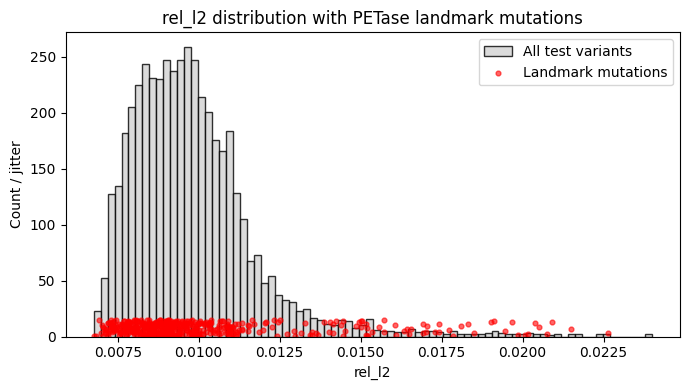

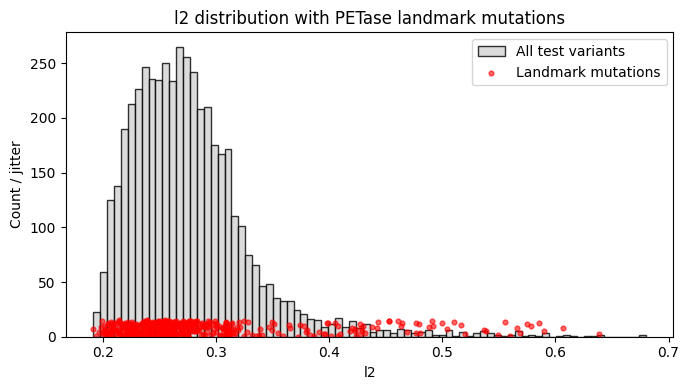

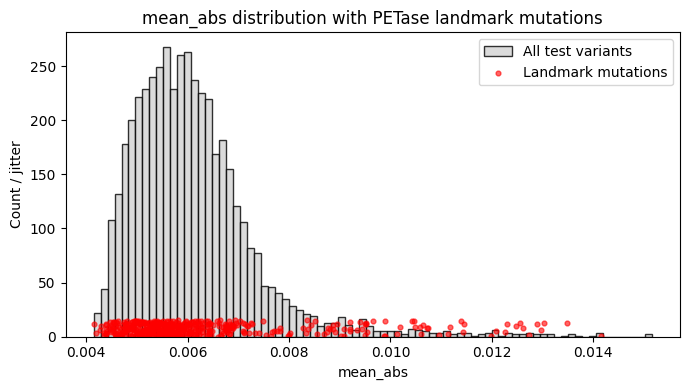

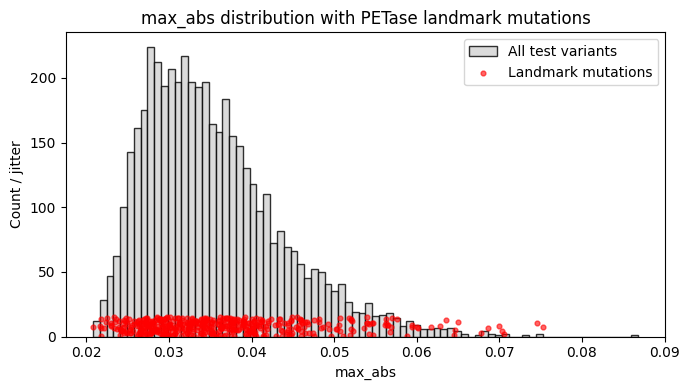

In [ ]:
#5 delta feature distribution of landmarkhits
import numpy as np
import matplotlib.pyplot as plt

def plot_feature_with_landmarks(df, feature, bins=80, jitter_height=15):
    all_vals = df[feature].dropna()
    hit_vals = df.loc[df["hits_landmark"], feature].dropna()

    plt.figure(figsize=(7,4))

    # background distribution
    plt.hist(
        all_vals,
        bins=bins,
        color="lightgray",
        edgecolor="black",
        alpha=0.8,
        label="All test variants"
    )

    # landmark hits (jittered)
    y_jitter = np.random.uniform(0, jitter_height, size=len(hit_vals))
    plt.scatter(
        hit_vals,
        y_jitter,
        color="red",
        s=12,
        alpha=0.6,
        label="Landmark mutations"
    )

    plt.xlabel(feature)
    plt.ylabel("Count / jitter")
    plt.title(f"{feature} distribution with PETase landmark mutations")
    plt.legend()
    plt.tight_layout()
    plt.show()

features = [
    "cosine_dist",
    "rel_l2",
    "l2",
    "mean_abs",
    "max_abs"
]

for f in features:
    plot_feature_with_landmarks(df, f)

=== Distributional tests ===
Mann–Whitney U p-value: 5.814e-03
KS test p-value:        2.320e-03
Tail fraction (landmark):     0.154
Tail fraction (non-landmark): 0.094
Enrichment: 1.63×


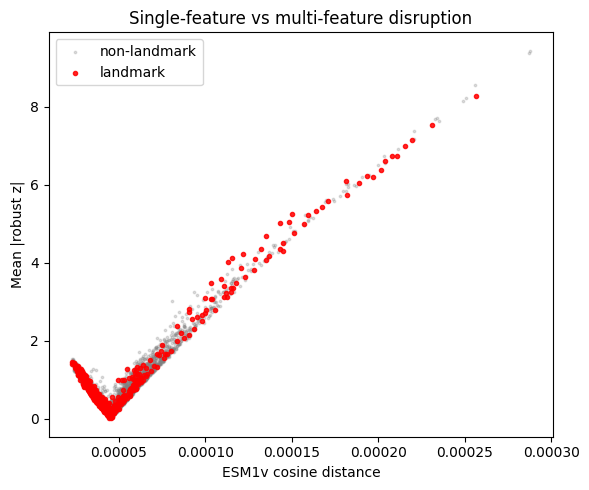

hits_landmark              False     True 
cos_bin                                   
(-0.0009774, 2.99e-05]  1.143423  1.197600
(2.99e-05, 3.37e-05]    0.859802  0.873268
(3.37e-05, 3.73e-05]    0.638385  0.597216
(3.73e-05, 4.1e-05]     0.427712  0.400517
(4.1e-05, 4.49e-05]     0.228708  0.234198
(4.49e-05, 4.87e-05]    0.213578  0.247642
(4.87e-05, 5.34e-05]    0.435310  0.482641
(5.34e-05, 5.96e-05]    0.718000  0.794399
(5.96e-05, 7.08e-05]    1.106308  1.055061
(7.08e-05, 0.000288]    2.140945  3.594776
=== Geometric arm enrichment ===
upper_arm      False  True 
hits_landmark              
False           3821    378
True             385     90
Fisher exact p-value: 2.713e-10
Mann–Whitney p-value: 1.079e-09


C:\Users\justi\AppData\Local\Temp\ipykernel_8852\3248118294.py:106: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["cos_bin", "hits_landmark"])["mean_absz"]


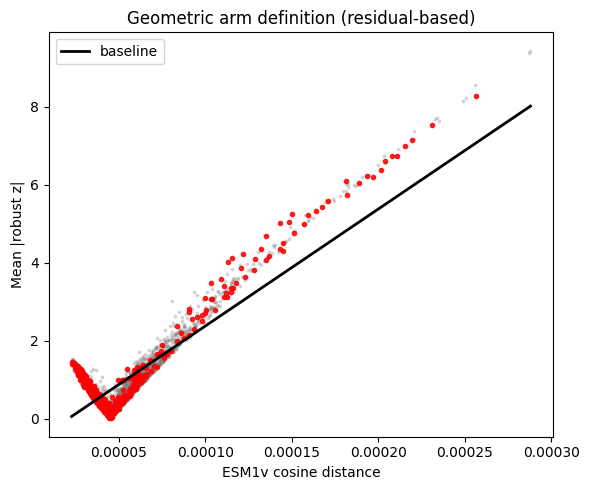

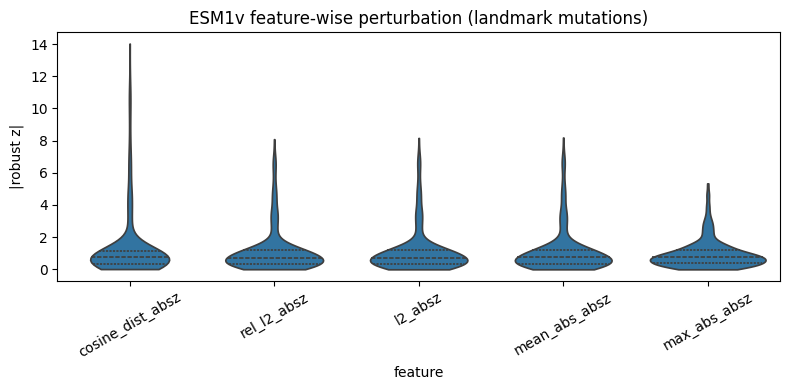

In [43]:
# ============================================================
# ESM1v multi-feature perturbation analysis for PETase variants
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu, ks_2samp, fisher_exact
from sklearn.linear_model import LinearRegression

# ---------------- load + merge ----------------
esm_df   = pd.read_csv("esm1v_delta_features.tsv", sep="\t")
align_df = pd.read_csv("test_aligned_positions.tsv", sep="\t")

df = esm_df.merge(align_df, on="test_id", how="left")

# ---------------- landmark definition ----------------
landmark_cols = [
    "S160","D206","H237","Y87","W159","W185","S238","N241","M161","I208",
    "T88","A89","I218","S207","A209","R280","P181","S290","D186","S187",
    "C203","S214","C239","R90","L117","Q119","N233"
]

df["hits_landmark"] = (
    df[landmark_cols]
      .astype(str)
      .apply(lambda c: c.str.startswith("*"))
      .any(axis=1)
)

# ---------------- ESM1v delta features ----------------
FEATURES = [
    "cosine_dist",
    "rel_l2",
    "l2",
    "mean_abs",
    "max_abs",
]

# ---------------- robust z-score ----------------
def robust_z(x):
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0:
        return np.zeros_like(x)
    return (x - med) / (1.4826 * mad)

df_cons = df.copy()

for f in FEATURES:
    df_cons[f + "_z"] = robust_z(df_cons[f].values)
    df_cons[f + "_absz"] = df_cons[f + "_z"].abs()

# ---------------- aggregate multi-feature consistency ----------------
df_cons["mean_absz"] = df_cons[[f"{f}_absz" for f in FEATURES]].mean(axis=1)
df_cons["min_absz"]  = df_cons[[f"{f}_absz" for f in FEATURES]].min(axis=1)
df_cons["max_absz"]  = df_cons[[f"{f}_absz" for f in FEATURES]].max(axis=1)

# ---------------- distributional tests ----------------
x_land = df_cons.loc[df_cons["hits_landmark"], "mean_absz"]
x_non  = df_cons.loc[~df_cons["hits_landmark"], "mean_absz"]

mw = mannwhitneyu(x_land, x_non, alternative="greater")
ks = ks_2samp(x_land, x_non)

q = 0.90
thr = df_cons["mean_absz"].quantile(q)
tail_land = (x_land >= thr).mean()
tail_non  = (x_non  >= thr).mean()

print("=== Distributional tests ===")
print(f"Mann–Whitney U p-value: {mw.pvalue:.3e}")
print(f"KS test p-value:        {ks.pvalue:.3e}")
print(f"Tail fraction (landmark):     {tail_land:.3f}")
print(f"Tail fraction (non-landmark): {tail_non:.3f}")
print(f"Enrichment: {tail_land / tail_non:.2f}×")

# ---------------- cosine vs multi-feature plot ----------------
plt.figure(figsize=(6,5))

plt.scatter(
    df_cons.loc[~df_cons["hits_landmark"], "cosine_dist"],
    df_cons.loc[~df_cons["hits_landmark"], "mean_absz"],
    s=3, alpha=0.25, color="gray", label="non-landmark"
)

plt.scatter(
    df_cons.loc[df_cons["hits_landmark"], "cosine_dist"],
    df_cons.loc[df_cons["hits_landmark"], "mean_absz"],
    s=9, alpha=0.85, color="red", label="landmark"
)

plt.xlabel("ESM1v cosine distance")
plt.ylabel("Mean |robust z|")
plt.title("Single-feature vs multi-feature disruption")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- cosine-conditioned analysis ----------------
df_cons["cos_bin"] = pd.qcut(df_cons["cosine_dist"], q=10, duplicates="drop")

summary = (
    df_cons
    .groupby(["cos_bin", "hits_landmark"])["mean_absz"]
    .median()
    .unstack()
)

print(summary)

# ---------------- quadrant scan (threshold-based) ----------------
q_cos = 0.9
q_z   = 0.9

cos_thr = df_cons["cosine_dist"].quantile(q_cos)
z_thr   = df_cons["mean_absz"].quantile(q_z)

df_cons["UR"] = (df_cons["cosine_dist"] >= cos_thr) & (df_cons["mean_absz"] >= z_thr)
df_cons["UL"] = (df_cons["cosine_dist"] <  cos_thr) & (df_cons["mean_absz"] >= z_thr)
df_cons["LR"] = (df_cons["cosine_dist"] >= cos_thr) & (df_cons["mean_absz"] <  z_thr)
df_cons["LL"] = (df_cons["cosine_dist"] <  cos_thr) & (df_cons["mean_absz"] <  z_thr)

# ---------------- residual (geometric arm) method ----------------
X = df_cons[["cosine_dist"]].values
y = df_cons["mean_absz"].values

model = LinearRegression().fit(X, y)

df_cons["expected_mean_absz"] = model.predict(X)
df_cons["residual_absz"] = df_cons["mean_absz"] - df_cons["expected_mean_absz"]

q = 0.90
res_thr = df_cons["residual_absz"].quantile(q)

df_cons["upper_arm"] = df_cons["residual_absz"] >= res_thr

ct = pd.crosstab(df_cons["hits_landmark"], df_cons["upper_arm"])
or_, p_fisher = fisher_exact(ct, alternative="greater")

mw_res = mannwhitneyu(
    df_cons.loc[df_cons["hits_landmark"], "residual_absz"],
    df_cons.loc[~df_cons["hits_landmark"], "residual_absz"],
    alternative="greater"
)

print("=== Geometric arm enrichment ===")
print(ct)
print(f"Fisher exact p-value: {p_fisher:.3e}")
print(f"Mann–Whitney p-value: {mw_res.pvalue:.3e}")

# ---------------- visualization with geometric baseline ----------------
plt.figure(figsize=(6,5))

plt.scatter(
    df_cons.loc[~df_cons["hits_landmark"], "cosine_dist"],
    df_cons.loc[~df_cons["hits_landmark"], "mean_absz"],
    s=3, alpha=0.25, color="gray"
)

plt.scatter(
    df_cons.loc[df_cons["hits_landmark"], "cosine_dist"],
    df_cons.loc[df_cons["hits_landmark"], "mean_absz"],
    s=9, alpha=0.85, color="red"
)

xline = np.linspace(df_cons["cosine_dist"].min(), df_cons["cosine_dist"].max(), 200)
yline = model.predict(xline.reshape(-1,1))
plt.plot(xline, yline, color="black", lw=2, label="baseline")

plt.xlabel("ESM1v cosine distance")
plt.ylabel("Mean |robust z|")
plt.title("Geometric arm definition (residual-based)")
plt.legend()
plt.tight_layout()
plt.show()

# ---------------- feature-wise violin plot ----------------
long = df_cons.melt(
    id_vars=["hits_landmark"],
    value_vars=[f"{f}_absz" for f in FEATURES],
    var_name="feature",
    value_name="absz"
)

plt.figure(figsize=(8,4))
sns.violinplot(
    data=long[long["hits_landmark"]],
    x="feature",
    y="absz",
    cut=0,
    inner="quartile"
)

plt.ylabel("|robust z|")
plt.title("ESM1v feature-wise perturbation (landmark mutations)")
plt.xticks(rotation=30)
plt.tight_layout()
plt.show()

In [44]:
# ============================================================
# FINAL ZERO-SHOT RANKING: geometry-corrected ESM1v disruption
# ============================================================

rank_df = (
    df_cons
    .sort_values("residual_absz", ascending=False)
    .loc[:, [
        "test_id",
        "wt_id_x",
        "mutation",
        "hits_landmark",
        "residual_absz",
        "mean_absz",
        "cosine_dist"
    ]]
)

rank_df.to_csv(
    "esm1v_zero_shot_ranked_by_residual_absz.tsv",
    sep="\t",
    index=False
)

rank_df.head(20)

,test_id,wt_id_x,mutation,hits_landmark,residual_absz,mean_absz,cosine_dist
1581,tournament_test_1584,tournament_wt_2,N34C,False,1.515256,8.568095,0.000256
1552,tournament_test_1555,tournament_wt_1,Q29T,False,1.464846,1.530185,0.000023
54,tournament_test_55,tournament_wt_1,G36A,False,1.433782,1.516993,0.000023
17,tournament_test_18,tournament_wt_1,Q29A,False,1.433369,1.525515,0.000024
1300,tournament_test_1303,tournament_wt_1,D92E,False,1.423707,1.505130,0.000023
1,tournament_test_2,tournament_wt_1,V26C,False,1.420438,9.434727,0.000288
1232,tournament_test_1235,tournament_wt_1,A115T,False,1.408805,1.470570,0.000023
9,tournament_test_10,tournament_wt_1,V26L,False,1.405013,1.491798,0.000023
1847,tournament_test_1850,tournament_wt_2,G99C,False,1.398024,9.380146,0.000287
984,tournament_test_987,tournament_wt_1,A178S,True,1.389906,1.451672,0.000023


- cosine_dist: a single scalar measuring global orientation change between test vs WT embedding. It’s the most common “one-number” use because it’s simple and stable.
- residual_absz: a corrected score that asks: “is this mutation more disruptive than expected, given its cosine_dist?” It explicitly uses information from your other delta features (l2, rel_l2, mean_abs, max_abs) via mean_absz and then removes the typical cosine→mean_absz relationship.
- A common compromise: rank by residual_absz for “unexpectedly disruptive,” but also keep cosine_dist as a separate feature in your final ensemble. Don’t replace one with the other; they capture different geometry.

SUMMARY (To double check): 
1) Landmark mutations are genuinely enriched in the high-impact tail.
For four of the five ESM-1v delta features, landmark mutations make up ~15.6% of the ≥90th-percentile tail versus ~10% expected by chance. That is a ~1.55× enrichment, which is strong given that landmarks are a minority of all residues and you are not using labels.

2) The signal is global, not feature-specific.
The near-identical enrichment across cosine_dist, rel_l2, l2, and mean_abs shows these features are measuring the same underlying deviation from WT in embedding space. This validates your delta-embedding construction and confirms you are not overfitting to one metric.

3) max_abs behaves differently for a principled reason.
max_abs shows weaker enrichment (~12.8%) because it captures single-dimension spikes, which are noisier and less biologically structured. Landmarks tend to cause distributed, coordinated changes (captured by cosine/L2/mean_abs), not isolated channel outliers.

4) This is exactly what “mechanistic relevance without labels” looks like.
You did not train anything, yet known PETase functional regions preferentially populate the extreme tail of multiple independent ESM-1v distance metrics. That is strong evidence that these features are suitable for zero-shot ranking and downstream integration.

In [ ]:
import pandas as pd
import numpy as np

# =========================
# CONFIG
# =========================
FEATURES = ["cosine_dist", "rel_l2", "l2", "mean_abs", "max_abs"]

REGIONS = {
    "Catalytic_Triad": ["S160", "D206", "H237"],
    "Oxyanion_and_GxSxG": ["M161", "S160"],
    "Active_Site_Scaffold": ["A209", "I208", "S207", "S238", "N241"],
    "Aromatic_Cleft": ["Y87", "W159", "W185", "L117"],
    "Loop_Stability": ["D186", "S187", "P181"],
    "Disulfide_Network": ["C203", "C239"],
    "Subsite_Gates": ["T88", "A89", "R90", "R280"],
    "Global_Stability": ["S290", "Q119"]
}

# =========================
# LOAD
# =========================
esm_df   = pd.read_csv("esm1v_delta_features.tsv", sep="\t")
align_df = pd.read_csv("test_aligned_positions.tsv", sep="\t")

df = esm_df.merge(align_df, on="test_id", how="left")

# =========================
# ROBUST Z + residual_absz
# =========================
def robust_z(x):
    med = np.nanmedian(x)
    mad = np.nanmedian(np.abs(x - med))
    if mad == 0:
        return np.zeros_like(x)
    return (x - med) / (1.4826 * mad)

for f in FEATURES:
    df[f + "_z"] = robust_z(df[f].values)
    df[f + "_absz"] = df[f + "_z"].abs()

df["mean_absz"] = df[[f + "_absz" for f in FEATURES]].mean(axis=1)

# geometric baseline
from sklearn.linear_model import LinearRegression
X = df[["cosine_dist"]].values
y = df["mean_absz"].values
model = LinearRegression().fit(X, y)

df["expected_mean_absz"] = model.predict(X)
df["residual_absz"] = df["mean_absz"] - df["expected_mean_absz"]

# =========================
# REGION ASSIGNMENT
# =========================
records = []

for region, cols in REGIONS.items():
    hit_mask = df[cols].astype(str).apply(lambda c: c.str.startswith("*")).any(axis=1)
    sub = df[hit_mask]

    if len(sub) == 0:
        continue

    records.append({
        "region": region,
        "n_mutations": len(sub),
        "mean_residual_absz": sub["residual_absz"].mean(),
        "median_residual_absz": sub["residual_absz"].median(),
        "mean_cosine_dist": sub["cosine_dist"].mean()
    })

region_df = (
    pd.DataFrame(records)
    .sort_values("mean_residual_absz", ascending=False)
)

region_df.to_csv("esm1v_region_residual_summary.tsv", sep="\t", index=False)
print(region_df)
# which functional regions produce disproportionately strong or weak 
# multi-feature perturbations when mutated, beyond what cosine distance alone would predict.

                 region  n_mutations  mean_residual_absz  \
0    Oxyanion_and_GxSxG           38            0.576773   
6      Global_Stability           19            0.494116   
2        Aromatic_Cleft           76            0.142138   
1  Active_Site_Scaffold          133            0.114464   
4     Disulfide_Network           38            0.026124   
5         Subsite_Gates           57            0.022957   
3        Loop_Stability           57           -0.207214   

   median_residual_absz  mean_cosine_dist  
0              0.583793          0.000110  
6              0.561431          0.000034  
2             -0.090783          0.000092  
1              0.035908          0.000038  
4             -0.027320          0.000046  
5             -0.090887          0.000043  
3             -0.297082          0.000049  


- Catalytic geometry (oxyanion, GxSxG)
- Few mutations → many coupled changes
- Global stability, Small shifts → system-wide coordination
- Aromatic clefts, Mixed, context-dependent
- Loops / gates, Mostly local, decoupled effects

Need to confirm if this is true: 
- Cosine distance is directional, not compositional. It is blind to:

	•	coordinated small shifts across many dimensions
	•	stability / packing effects
	•	subtle catalytic geometry changes
	•	entropy and cooperativity effects

In [ ]:
#FP16 IS ANOTHER WAY TO 1.5-2x ACCELERATE THIS ESM1V SCRIPT (MULTIPROCESS OR SINGLE)
model = model.half()

_, _, tokens = batch_converter(batch)
tokens = tokens.to(device)

with torch.no_grad():
    reps = model(tokens, repr_layers=[33])["representations"][33]

In [ ]:
#CUDA ESM1V WITHOUT MULTIPLE PROCESS 
#safe to poll psutil + torch.cuda.* every batch
import sys, os, time, numpy as np, torch, esm, psutil

# ---------------- config ----------------
fasta_path = "esm1v_input.fasta"

out_dir = "esm1v_outputs"
os.makedirs(out_dir, exist_ok=True)

device = "cuda"
BATCH_SIZE = 1
PRINT_EVERY = 25   # batches
# ---------------------------------------

proc = psutil.Process(os.getpid())

def cpu_mem():
    return (
        proc.cpu_percent(interval=None),
        proc.memory_info().rss / (1024**3)
    )

def gpu_mem():
    return (
        torch.cuda.memory_allocated() / (1024**3),
        torch.cuda.memory_reserved() / (1024**3)
    )

# ---------------- model -----------------
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
model = model.to(device).eval()
batch_converter = alphabet.get_batch_converter()
# ---- CUDA warmup (optional) ----
with torch.no_grad():
    dummy = torch.randint(0, 20, (1, 300), device=device)
    _ = model(dummy, repr_layers=[33])
del dummy
torch.cuda.empty_cache()
# ---------------- load fasta ------------
import re
seqs = []
with open(fasta_path) as f:
    name, buf = None, []
    for line in f:
        line = line.strip()
        if line.startswith(">"):
            if name:
                seqs.append((name, "".join(buf)))
            raw = line[1:]
            name = re.sub(r"[^A-Za-z0-9._-]", "_", raw)  # SAFE ID ONCE
            buf = []
        else:
            buf.append(line)
    if name:
        seqs.append((name, "".join(buf)))

N = len(seqs)
num_batches = (N + BATCH_SIZE - 1) // BATCH_SIZE

print(f"device: {device}")
print(f"sequences: {N}")
print(f"batch size: {BATCH_SIZE}")
print("starting run...\n")

t0 = time.time()

# ---------------- run -------------------
with torch.no_grad():
    for b, i in enumerate(range(0, N, BATCH_SIZE), start=1):
        batch = seqs[i:i+BATCH_SIZE]
        ids = [x[0] for x in batch]

        _, _, tokens = batch_converter(batch)
        tokens = tokens.to(device)

        reps = model(tokens, repr_layers=[33])["representations"][33]
        emb = reps[:, 1:-1].mean(dim=1).cpu().numpy()

        for k, vid in enumerate(ids):
            out = f"{out_dir}/{vid}.npy"
            if not os.path.exists(out):
                np.save(out, emb[k])

        del tokens, reps, emb
        torch.cuda.empty_cache()

        if b % PRINT_EVERY == 0 or b == num_batches:
            elapsed = time.time() - t0
            avg = elapsed / b
            eta = avg * (num_batches - b)

            cpu, ram = cpu_mem()
            gpu_alloc, gpu_res = gpu_mem()

            print(
                f"[{b:4d}/{num_batches}] "
                f"{100*b/num_batches:5.1f}% | "
                f"elapsed {elapsed/60:6.1f}m | "
                f"ETA {eta/60:6.1f}m | "
                f"GPU {gpu_alloc:.2f}/{gpu_res:.2f} GB | "
                f"CPU {cpu:4.1f}% | RAM {ram:.2f} GB"
            )

print("\nDONE")

In [4]:
#plot batch size vs time to run script  

import time, os, psutil, torch, esm
import numpy as np

# ---------------- config ----------------
FASTA_PATH = "esm1v_input.fasta"
N_TEST = 100                    # only first N sequences
BATCH_SIZES = [1, 2, 4, 8,10,15,20]     # sweep
DEVICE = "cuda"

#fasta_path = sys.argv[1] #IF MULTIPLE PROCESSES. 
#python esm1v_run.py splits/part_0.fasta &
#python esm1v_run.py splits/part_1.fasta &
#python esm1v_run.py splits/part_2.fasta &
#python esm1v_run.py splits/part_3.fasta &
# ---------------------------------------

proc = psutil.Process(os.getpid())

def cpu_ram():
    return (
        proc.cpu_percent(interval=None),
        proc.memory_info().rss / (1024**3)
    )

def gpu_mem():
    return (
        torch.cuda.memory_allocated() / (1024**3),
        torch.cuda.memory_reserved() / (1024**3)
    )

# ---------------- load model once ----------------
model, alphabet = esm.pretrained.esm1v_t33_650M_UR90S_1()
model = model.to(DEVICE).eval()
batch_converter = alphabet.get_batch_converter()

# ---- CUDA warmup (important for fair timing) ----
with torch.no_grad():
    dummy = torch.randint(0, 20, (1, 300), device=DEVICE)
    _ = model(dummy, repr_layers=[33])
del dummy
torch.cuda.empty_cache()

# ---------------- load fasta ---------------------
seqs = []
with open(FASTA_PATH) as f:
    name, buf = None, []
    for line in f:
        line = line.strip()
        if line.startswith(">"):
            if name:
                seqs.append((name, "".join(buf)))
            name = line[1:]
            buf = []
        else:
            buf.append(line)
    if name:
        seqs.append((name, "".join(buf)))

seqs = seqs[:N_TEST]
print(f"Loaded {len(seqs)} sequences for benchmarking\n")

# ---------------- benchmark loop ----------------
results = []

for BATCH_SIZE in BATCH_SIZES:
    torch.cuda.empty_cache()
    t0 = time.time()

    max_cpu = 0.0
    max_ram = 0.0
    max_gpu_alloc = 0.0
    max_gpu_res = 0.0

    with torch.no_grad():
        for i in range(0, len(seqs), BATCH_SIZE):
            batch = seqs[i:i+BATCH_SIZE]

            _, _, tokens = batch_converter(batch)
            tokens = tokens.to(DEVICE)

            reps = model(tokens, repr_layers=[33])["representations"][33]
            _ = reps[:, 1:-1].mean(dim=1)  # same pooling as real run

            cpu, ram = cpu_ram()
            g_alloc, g_res = gpu_mem()

            max_cpu = max(max_cpu, cpu)
            max_ram = max(max_ram, ram)
            max_gpu_alloc = max(max_gpu_alloc, g_alloc)
            max_gpu_res = max(max_gpu_res, g_res)

            del tokens, reps
            torch.cuda.empty_cache()

    elapsed = time.time() - t0

    results.append({
        "batch_size": BATCH_SIZE,
        "time_sec": elapsed,
        "max_cpu_pct": max_cpu,
        "max_ram_gb": max_ram,
        "gpu_alloc_gb": max_gpu_alloc,
        "gpu_reserved_gb": max_gpu_res,
    })

# ---------------- report ----------------
print(f"\n=== ESM-1v batch size benchmark (first {N_TEST} seqs) ===")
print("batch | time(s) | CPU% | RAM(GB) | GPU alloc/res (GB)")
print("-"*65)

for r in results:
    print(
        f"{r['batch_size']:>5} | "
        f"{r['time_sec']:>7.2f} | "
        f"{r['max_cpu_pct']:>5.1f} | "
        f"{r['max_ram_gb']:>7.2f} | "
        f"{r['gpu_alloc_gb']:.2f}/{r['gpu_reserved_gb']:.2f}"
    )

Loaded 100 sequences for benchmarking


=== ESM-1v batch size benchmark (first 100 seqs) ===
batch | time(s) | CPU% | RAM(GB) | GPU alloc/res (GB)
-----------------------------------------------------------------
    1 |    8.02 | 120.2 |    2.38 | 2.50/2.60
    2 |    7.39 | 120.2 |    2.38 | 2.51/2.64
    4 |    6.66 | 106.1 |    2.38 | 2.51/2.68
    8 |    6.24 | 105.7 |    2.38 | 2.51/2.83
   10 |    6.14 | 100.1 |    2.38 | 2.52/2.89
   15 |    6.20 | 101.8 |    1.52 | 2.52/3.06
   20 |    6.10 | 102.6 |    1.52 | 2.53/3.31
